# {{ben}}
This page describes the usage of Dataloader and Datamodule for {{ben}}, a multi-spectral multilabel Remote Sensing Land-Use/Land-Cover classification dataset.

The official paper of the {{ben}} (BigEarthNet-S2) dataset was initially published in {cite:t}`BEN` and updated to multi-modal {{ben}} in {cite:t}`BEN19labels`.

For detailed information on the dataset itself please refer to the publications and the {{bendocs}}.

In [13]:
# remove-input
# remove-output
import matplotlib.pyplot as plt
import pathlib
from pprint import pprint
import torch

my_data_path = str(pathlib.Path("").resolve().parent.parent.parent.joinpath("configilm").joinpath("extra").joinpath("mock_data").resolve(strict=True))

The dataset is divided into two modules which contains two `classes`, a standard `torch.util.data.Dataset` and a `pytorch_lightning.LightningDataModule` that encapsulates the `Dataset` for easy use in `pytorch_lightning` applications. The `Dataset` uses a `BENLMDBReader` to read images and labels from a LMDB file. Labels are returned in their 19-label version as one-hot vector.

## BENDataSet

In its most basic form, the `Dataset` only needs the base path of the LMDB file and csv files, if the path is not "./". The LMDB file name is assumed to be `BigEarthNetEncoded.lmdb` (note, that from an os point of view, LMDB files are folders). This `Dataset` will load 12 channels (10m + 20m Sentinel-2 + 10m Sentinel-1).

The full folder structure expected is
```
.
├── BigEarthNetEncoded.lmdb
│   ├── data.mdb
│   └── lock.mdb
├── test.csv
├── train.csv
└── val.csv
```

In [14]:
from configilm.extra.DataSets import BEN_DataSet
from configilm.extra.DataModules import BEN_DataModule

ds = BEN_DataSet.BENDataSet(
    root_dir=my_data_path  # path set by to dataset
)

img, lbl = ds[26]
img = torch.flip(img[:3], [0]) # only choose BGR axis for display and bring into RGB order

Loading BEN data for None...
    75 patches indexed
    75 filtered patches indexed


Size: torch.Size([3, 120, 120])
Labels:
tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0.])


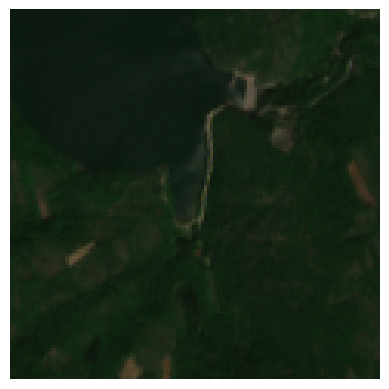

In [15]:
# remove-input
print(f"Size: {img.shape}")
print("Labels:")
pprint(lbl)
# images are 12 bit of radiometric resolution, so to display simply divide by 2^12
# this will not be the best way of displaying but enough as a showcase
img /= 2**12

_ = plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()

### Selecting Bands

The `Dataset` also supports different channel configurations, however, setting the selected channels is only supported via image size selection and only limited combinations are available. To see the available combinations call `BEN_DataModule_LMDB_Encoder.BENDataSet.get_available_channel_configurations()`. Alternatively, a faulty configuration will display the possibilities as well whilst raising an `AssertionError`.

The configurations are working like setting the respective number as `bands` parameter in the `LMDBReader`.

In [16]:
BEN_DataSet.BENDataSet.get_available_channel_configurations()

Available channel configurations are:
      2 -> Sentinel-1
      3 -> RGB
      4 -> 10m Sentinel-2
     10 -> 10m + 20m Sentinel-2
     12 -> 10m + 20m Sentinel-2 + 10m Sentinel-1


### Splits

It is possible to load only a specific split (`'train'`, `'val'` or `'test'`) in the dataset. The images loaded are specified using the csv files in the same folder as the LMDB file. By default (`None`), all three are loaded into the same `Dataset`.

In [17]:
_ = BEN_DataSet.BENDataSet(
    root_dir=my_data_path,  # path set by to dataset
    split="train"
)

Loading BEN data for train...
    25 patches indexed
    25 filtered patches indexed


### Restricting the number of loaded images

It is also possible to restrict the number of images indexed. By setting `max_img_idx = n` only the first `n` images (in alphabetical order based on their S2-name) will be loaded. A `max_img_idx` of  `None`, `-1` or larger than the number of images in the csv file(s) (in this case 25) equals to load-all-images behaviour.

In [18]:
_ = BEN_DataSet.BENDataSet(
    root_dir=my_data_path,  # path set by to dataset
    split="train",
    max_img_idx=10
)

Loading BEN data for train...
    25 patches indexed
    10 filtered patches indexed


In [19]:
_ = BEN_DataSet.BENDataSet(
    root_dir=my_data_path,  # path set by to dataset
    split="train",
    max_img_idx=100
)

Loading BEN data for train...
    25 patches indexed
    25 filtered patches indexed


## BENDataModule

This class is a [Lightning Data Module](https://pytorch-lightning.readthedocs.io/en/stable/data/datamodule.html), that wraps the `BENDataSet`. It automatically generates `DataLoader` per split with augmentations, shuffling, etc., depending on the split. All images are resized and normalized and images in the train set additionally basic-augmented via noise and flipping/rotation. The train split is also shuffled, however this can be overwritten (see below).

To use a `DataModule`, the `setup()` function has to be called. This populates the `Dataset` splits inside the `DataModule`. Depending on the stage (`'fit'`, `'test'` or `None`), the setup will prepare only train & validation `Dataset`, only test `Dataset` or all three.

In [20]:
dm = BEN_DataModule.BENDataModule(
    data_dir=my_data_path  # path set by to dataset
)
print("Before:")
print(dm.train_ds)
print(dm.val_ds)
print(dm.test_ds)

print("\n=== SETUP ===")
dm.setup(stage="fit")
print("=== END SETUP ===\n")
print("After:")
print(dm.train_ds)
print(dm.val_ds)
print(dm.test_ds)

Dataloader using 10 workers
Before:
None
None
None

=== SETUP ===
(17:05:43) Datamodule setup called
Loading BEN data for train...
    25 patches indexed
    25 filtered patches indexed
Loading BEN data for val...
    25 patches indexed
    25 filtered patches indexed
setup took 0.00 seconds
  Total training samples:       25  Total validation samples:       25
=== END SETUP ===

After:
None


Afterwards the pytorch `DataLoader` can be easily accessed. Note, that $len(DL) = \lceil \frac{len(DS)}{batch\_size} \rceil$, therefore here with the default `batch_size` of 16: 25/16 -> 2.

In [21]:
train_loader = dm.train_dataloader()
print(len(train_loader))

2


The `DataModule` has in addition to the `DataLoader` settings a parameter each for `data_dir`, `image_size` and `max_img_idx` which are passed through to the `DataSet`.

### DataLoader settings

The `DataLoader` have three settable parameters: `batch_size`, `num_workers_dataloader` and `shuffle` with 16, `os.cpu_count()` / 2 and `None` as their default values. A shuffle of `None` means, that the train set is shuffled but validation and test are not. Changing this setting will be accompanied by a Message-Hint printed.

Not changeable is the usage of pinned memory, which is set to `True` if a cuda-enabled device is found and `False` otherwise.

In [22]:
dm = BEN_DataModule.BENDataModule(
    data_dir=my_data_path,  # path set by to dataset
    batch_size=4
)
print("\n=== SETUP ===")
dm.setup(stage="fit")
print("=== END SETUP ===\n")
print(len(dm.train_dataloader()))

Dataloader using 10 workers

=== SETUP ===
(17:05:43) Datamodule setup called
Loading BEN data for train...
    25 patches indexed
    25 filtered patches indexed
Loading BEN data for val...
    25 patches indexed
    25 filtered patches indexed
setup took 0.00 seconds
  Total training samples:       25  Total validation samples:       25
=== END SETUP ===

7


In [23]:
_ = BEN_DataModule.BENDataModule(
    data_dir=my_data_path,  # path set by to dataset
    shuffle=False
)

Dataloader using 10 workers

HINT: Shuffle was set to False. This is not recommended for most configuration. Use shuffle=None (default) for recommended configuration.


In [24]:
_ = BEN_DataModule.BENDataModule(
    data_dir=my_data_path,  # path set by to dataset
    num_workers_dataloader=2
)

Dataloader using 2 workers
